In [1]:
from niche_fit import *
from niche_calib import *
from read_flasher_logs import *

from utils import *
import matplotlib.pyplot as plt
%matplotlib widget

In [2]:
# counters = ['bardeen','bell','curie','feynman','newton','noether','rossi','rubin','rutherford']
counters = ['bardeen','bell','curie','feynman','newton','noether','rossi','rubin']
calib_dict = {}
amp_dict = {}
for counter in counters:
    nraws = read_calib_files(counter)
    calibs = np.array([CalibPulse(r) for r in nraws],dtype='O')
    pulse_levels = np.array([c.pulse_mean for c in calibs])
    calibs = calibs[pulse_levels>40.]
    calib_dict[counter] = calibs
    trigtimes = np.array([c.trigtime() for c in calibs])
    amp_dict[counter] = np.array(run_multiprocessing(ampl_at_time,trigtimes))

|████████████████████████████████████████| 4867/4867 [100%] in 1.5s (3200.43/s) 
|████████████████████████████████████████| 5149/5149 [100%] in 1.5s (3446.84/s) 
|████████████████████████████████████████| 5033/5033 [100%] in 1.3s (3767.96/s) 
|████████████████████████████████████████| 5248/5248 [100%] in 2.3s (2245.18/s) 
|████████████████████████████████████████| 5237/5237 [100%] in 3.7s (1431.25/s) 
|████████████████████████████████████████| 5299/5299 [100%] in 3.0s (1762.21/s) 
|████████████████████████████████████████| 5551/5551 [100%] in 4.3s (1293.76/s) 
|████████████████████████████████████████| 5268/5268 [100%] in 3.9s (1359.38/s) 


In [3]:
ampset = np.arange(1,13) * 10.
ns_dict = {}
var_dict = {}
mean2_dict = {}
meanpa_dict = {}
meanpulse_dict = {}
for counter in counters:
    ns = []
    var = []
    mean2 = []
    meanpa = []
    meanpulse = []
    for amp in ampset:
        # PAs = np.array([c.pulse.sum() for c in calib_dict[counter][amp_dict[counter]==amp]])
        # PAs /= PAs.mean()
        pms = np.array([c.pulse.mean() for c in calib_dict[counter][amp_dict[counter]==amp]])
        # ns.append(PAs.mean()**2/np.var(PAs))
        # var.append(np.var(PAs))
        # mean2.append(PAs.mean()**2)
        # meanpa.append(PAs.mean())
        meanpulse.append(pms.mean())
    # ns_dict[counter] = np.array(ns)
    # var_dict[counter] = np.array(var)
    # mean2_dict[counter] = np.array(mean2)
    # meanpa_dict[counter] = np.array(meanpa)
    meanpulse_dict[counter] = np.array(meanpulse)

/tmp/ipykernel_19416/389252154.py:21: RuntimeWarning: Mean of empty slice.
  meanpulse.append(pms.mean())
/home/isaac/anaconda3/envs/py10/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [4]:
r = 62. #approximate cm
A = 77. #cm^2
niche_omega = A/r**2
pulse_time = 76*5. #in nanoseconds
qe = .35
# plt.figure()
# for counter in counters:
#     photons = ns_dict[counter] / qe
#     photons_per_omega_per_ns = photons / niche_omega / pulse_time
#     plt.scatter(ampset,photons_per_omega_per_ns, label = counter)
    

Text(0, 0.5, 'mean pulse level')

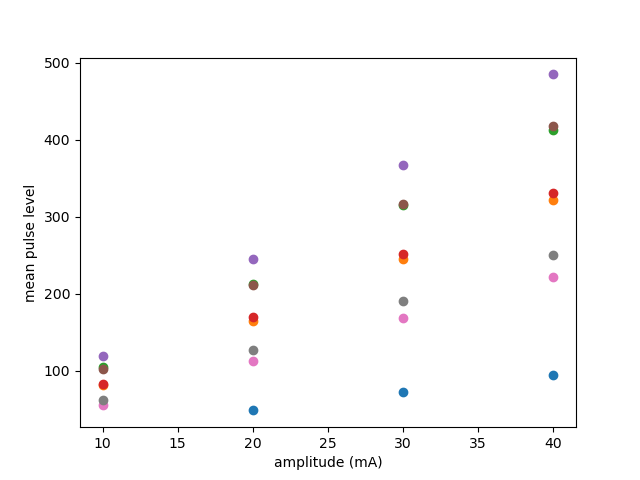

In [5]:
plt.figure()
for counter in counters:
    plt.scatter(ampset[:4], meanpulse_dict[counter][:4])
plt.xlabel('amplitude (mA)')
plt.ylabel('mean pulse level')

In [6]:
photons_per_omega_per_ns=np.array([3625.777169418993,
7371.932223605822,
10938.2824111218,
14059.85972612137])
photons_per_sample = photons_per_omega_per_ns * niche_omega * 5.

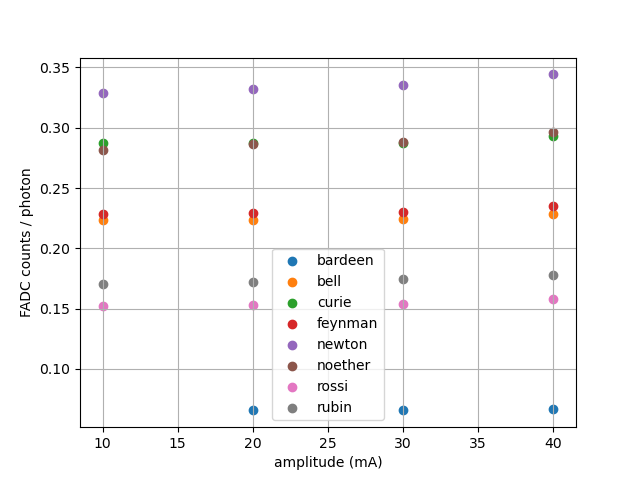

In [7]:
plt.figure()
for counter in counters:
    plt.scatter(ampset[:4], meanpulse_dict[counter][:4]/photons_per_sample, label=counter)
plt.xlabel('amplitude (mA)')
plt.ylabel('FADC counts / photon')
plt.legend()
plt.grid()

In [8]:
# ampfit = np.concatenate(([0,],ampset))
# photonfit = np.concatenate(([0,],photons_per_sample))
# err = [868.6849170442118, 1765.4355923544265, 2619.307345286065, 3366.7231356649404]
ampfit = ampset
photonfit = photons_per_sample

In [9]:
def linear(x: float | np.ndarray, m: float, b: float) -> float | np.ndarray:
    return m*x + b

from scipy.optimize import curve_fit

popt, pcov = curve_fit(linear, ampfit[:4], photonfit)

In [10]:
def e_output(amp: float | np.ndarray, a: float, b: float) -> float | np.ndarray:
    return a * (1 - np.exp(-amp/b))

popt1, pcov1 = curve_fit(e_output, ampfit[:4], photonfit, p0=(400,200))

In [11]:
pcov1

array([[1.19672343e+07, 3.33941468e+05],
       [3.33941468e+05, 9.32165157e+03]])

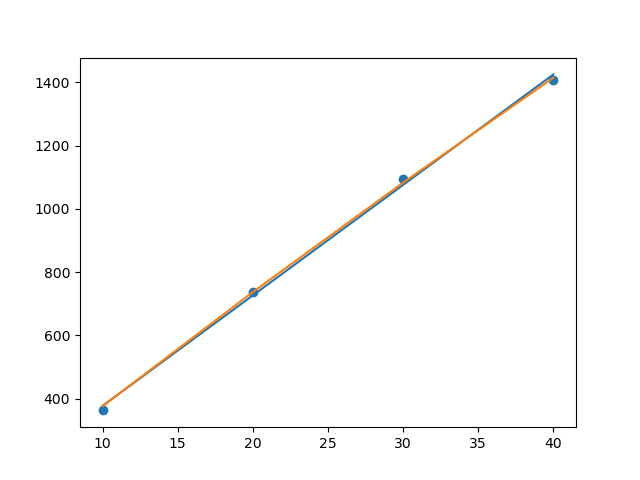

In [12]:
plt.figure()
plt.scatter(ampset[:4], photons_per_sample)
plt.plot(ampset[:4], linear(ampset[:4],*popt))
plt.plot(ampset[:4], e_output(ampset[:4],*popt1))

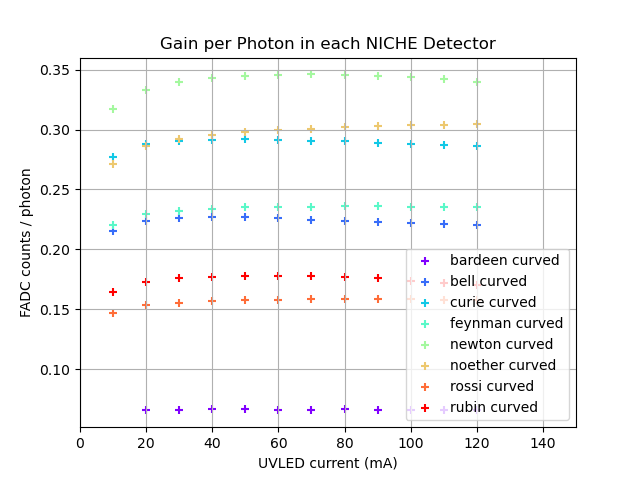

In [16]:
plt.figure()
c = np.arange(len(counters))
colors = plt.cm.rainbow(c/c.max())
for i,counter in enumerate(counters):
    # plt.scatter(ampset, meanpulse_dict[counter]/linear(ampset,*popt), color = colors[i], label = f'{counter} linear')
    plt.scatter(ampset, meanpulse_dict[counter]/e_output(ampset,*popt1), color = colors[i], marker='+', label = f'{counter} curved')
plt.xlabel('UVLED current (mA)')
plt.ylabel('FADC counts / photon')
plt.title('Gain per Photon in each NICHE Detector')
plt.xlim(0,150)
plt.grid()
plt.legend(loc=4)

In [14]:
nraws[0].date

b'20240413043513'

In [15]:
np.sqrt(pcov1)

array([[3459.36906427,  577.87668936],
       [ 577.87668936,   96.5487005 ]])